### Đa kênh Đầu vào và đầu ra
- Mặc dù chúng ta đã mô tả mỗi tấm ảnh được tạo nên bởi nhiều kênh (channel), cụ thể, ảnh màu sử dụng hệ màu RGB tiêu chuẩn với các kênh riêng biệt thể hiện lượng màu đỏ, xanh lá, xanh dương. Nhưng cho đến lúc này, ta vẫn đơn giản hóa tất cả các ví dụ tính toán với chỉ một kênh đầu vào và một kênh đầu ra. Đều đó cho phép ta coi các đầu vào, các bộ lọc tích chập và các đầu ra như mảng hai chiều.
- Khi chúng ta thêm các kênh vào hỗn hợp ấy, đầu vào cùng với các lớp biểu diễn ẩn của ta trở thành các mảng ba chiều. Ví dụ, mỗi ảnh RGB có dạng 3 x h x w. Ta xem trục này là chiều kênh, có kích thước là 3. Trong phần này, ta sẽ quan sát sâu hơn vào các bộ lọc tích chập với đầu vào và đầu ra đa kênh.

#### 1. Đa kênh đầu vào
- Khi dữ liệu đầu vào có nhiều kênh, ta cần xây dựng một bộ lọc tích chập cùng số kênh đầu vào như dữ liệu nhập để nó có thể thực hiện tính tương quan chéo.
- Giả sử số kênh của dữ liệu đầu vào là c_i -> số kênh đầu vào là c_i, nếu c_i = 1 thì bộ lọc tích chập đơn giản là một mảng hai chiều kích thước k_h x k_w
- Nếu c_i > 1 thì cần một bộ lọc chứa mảng có kích thước k_h x k_w cho __mỗi kênh của đầu vào__. Gộp c_i mảng này lại ta được một bộ lọc tích chập kích thước c_i x k_h x k_w. Vì đầu vào và bộ lọc đều có c_i kênh nên ta có thể thực hiện phép tương quan chéo trên từng cặp mảng hai chiều của đầu vào và bộ lọc cho mỗi kênh rồi __cộng kết quả của c_i kênh để tạo ra một mảng hai chiều__. -> Đây là kết quả của phép tương quan chéo hai chiều của dữ liệu đầu vào đa kênh và kênh bộ lọc tích chập đa đầu vào.

    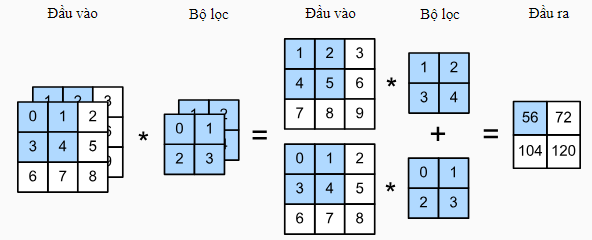

In [23]:
from d2l import mxnet as d2l
from mxnet import np, npx
npx.set_np()

def corr2d_multi_channel(X, K):
    sum = np.zeros(shape = d2l.corr2d(X[0], K[0]).shape)
    for x, k in zip(X, K):
        sum = sum + d2l.corr2d(x, k)
    return sum

X = np.array([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
              [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
K = np.array([[[0, 1], [2, 3]], [[1, 2], [3, 4]]])

corr2d_multi_channel(X, K)

array([[ 56.,  72.],
       [104., 120.]])

#### 2. Đa kênh đầu ra
- Cho đến nay, bất kể số lượng kênh đầu vào là bao nhiêu thì ta vẫn luôn kết thúc với chỉ một kênh đầu ra. Tuy nhiên, trong kiến trúc mạng nơ ron phổ biến nhất, ta thường tăng kích thước chiều kênh khi tiến sâu hơn trong mạng, đồng thời giảm độ phân giải không gian tương ứng để đánh đổi với chiều kênh sâu hơn.
- Đặt c_i và c_o lần lượt là số lượng kênh đầu vào và đầu ra, k_h và k_w lần lượt là chiều cao và chiều rộng của bộ lọc. Để có được một kênh đầu ra với nhiều kênh, ta có thể tạo ra một mảng bộ lọc có kích thước c_i x k_h x k_w cho mỗi kênh đầu ra. 
- Để tạo ra c_o đầu ra thì ta cần đúng c_o mảng bộ lọc kích thước c_i x k_h x k_w. Tức là khi này kích thước của bộ lọc tích chập sẽ là 

In [24]:
def corr2d_multi_in_out(X, K):
    return np.stack([corr2d_multi_channel(X, k) for k in K])

# Ta tạo một bộ lọc tích chập với ba kênh đầu ra bằng cách nối mảng bộ lọc K với K + 1, K + 2
K = np.stack((K, K + 1, K + 2))
K.shape


(3, 2, 2, 2)

In [25]:
corr2d_multi_in_out(X, K)

array([[[ 56.,  72.],
        [104., 120.]],

       [[ 76., 100.],
        [148., 172.]],

       [[ 96., 128.],
        [192., 224.]]])

#### 3. Tầng tích chập 1x1
- Thoạt nhìn, một phép tích chập 1 x 1 tức là k_h = k_w = 1 dường như không có nhiều ý nghĩa bởi một phép tích chập là để tính toán tương quan giữa các điểm ảnh liền kề nhưng rõ ràng một phép tích chập 1x1 lại không làm như vậy.
- Tuy nhiên, chúng là các phép tính phổ biến đôi khi được sử dụng để thiết kế các mạng sâu phức tạp. Ta sẽ xem cách hoạt động của chúng.
- Do cửa số có kích thước tối thiểu nên so với các tầng tích chập lớn hơn, phép tích chập 1 x 1 mất đi khả năng nhân dạng các khuôn mẫu chứa các tương tác giữa các phần tử liền kề theo chiều cao và chiều rộng. Phép tích chập 1x1 chỉ xảy ra theo chiều kênh.

    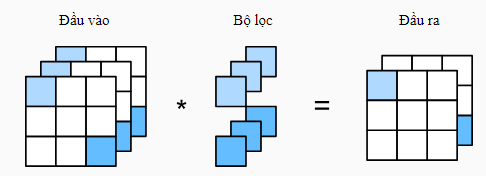

- Hình trên biểu diễn phép tính tương quan chéo sử dụng bộ lọc tích chập 1x1 với 3 kênh đầu vào và hai kênh đầu ra. Lưu ý tằng đầu vào và đầu ra có cùng chiều cao và chiều rộng. Mỗi phần tử trong đầu ra là một tổ hợp tuyến tính của các phần tử ở cùng một vị trí trong ảnh đầu vào. 
- Do đây là một tầng tích chập nên các trọng số sẽ được chia sẻ giữa các vị trí điểm ảnh, do đó tầng tích chập 1x1 cần tới c_0 x c_i trọng số.

In [29]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape(c_i, h * w)
    K = K.reshape(c_o, c_i)
    Y = np.dot(K, X)
    return Y.reshape(c_o, h, w)

In [33]:
X = np.random.uniform(size = (3, 3, 3))
K = np.random.uniform(size = (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)

(Y1 - Y2).sum() < 1e-6

array(True)

In [16]:
from mxnet.gluon import nn
from mxnet import np
conv2dtr = nn.Conv2DTranspose
X = np.ones(shape = (1, 1, 3, 3))
net = nn.Sequential()
net.add(nn.Conv2DTranspose(1, (2, 2), in_channels=1))
net.initialize()
X_legacy = X.as_nd_ndarray()  # Convert MXNet NumPy array to legacy NDArray
print(net(X_legacy))  # Forward pass



[[[[ 0.06700657  0.06331169  0.06331169 -0.00369488]
   [ 0.10888877  0.1473214   0.1473214   0.03843263]
   [ 0.10888877  0.1473214   0.1473214   0.03843263]
   [ 0.0418822   0.08400971  0.08400971  0.0421275 ]]]]
<NDArray 1x1x4x4 @cpu(0)>
